In [ ]:
# !pip install datasets

# The Datasets Library.

APart from using the HugginFace Hub , mostly we'll be using data from local machine. To load data from local `datasets` library has a lot of functions to load various filetypes.


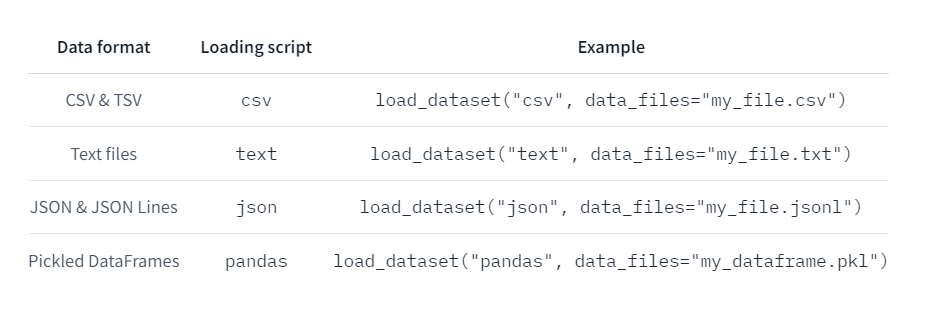

For this example we’ll use the **SQuAD-it dataset**, which is a large-scale dataset for question answering in Italian.

By default the `load_dataset()` loads the datatset into a `DatasetDict` format in train/test split.

In order to load the data , we need to know wether the data is in JSON or nested JSON format. Mostly all Q/A pairs are in nested format and the data is stored in `data` field. *Hence we should specify that in the `load_dataset` function arguments.

In [ ]:
# !wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
# !wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-test.json.gz

# !gzip -dkv SQuAD_it-*.json.gz

In [ ]:
from datasets import load_dataset

squad_it_dataset = load_dataset("json", data_files="SQuAD_it-train.json", field="data")

print("The DatasetDict object: ",squad_it_dataset)
print("One sample : ", squad_it_dataset["train"][0])


Generating train split: 0 examples [00:00, ? examples/s]

The DatasetDict object:  DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
})
One sample :  {'title': 'Terremoto del Sichuan del 2008', 'paragraphs': [{'context': "Il terremoto del Sichuan del 2008 o il terremoto del Gran Sichuan, misurato a 8.0 Ms e 7.9 Mw, e si è verificato alle 02:28:01 PM China Standard Time all' epicentro (06:28:01 UTC) il 12 maggio nella provincia del Sichuan, ha ucciso 69.197 persone e lasciato 18.222 dispersi.", 'qas': [{'answers': [{'answer_start': 29, 'text': '2008'}], 'id': '56cdca7862d2951400fa6826', 'question': 'In quale anno si è verificato il terremoto nel Sichuan?'}, {'answers': [{'answer_start': 232, 'text': '69.197'}], 'id': '56cdca7862d2951400fa6828', 'question': 'Quante persone sono state uccise come risultato?'}, {'answers': [{'answer_start': 29, 'text': '2008'}], 'id': '56d4f9902ccc5a1400d833c0', 'question': 'Quale anno ha avuto luogo il terremoto del Sichuan?'}, {'answers': [{'answer_start'

The data_files argument of the `load_dataset()` function is quite flexible and can be either a single file path, a list of file paths, or a dictionary that maps split names to file paths. You can also glob files that match a specified pattern according to the rules used by the Unix shell (e.g., you can glob all the JSON files in a directory as a single split by setting `data_files="*.json"`)

The loading scripts in 🤗 Datasets actually support automatic decompression of the input files including TAR, GZ, ZIP etc. so we could have skipped the use of gzip by pointing the data_files argument directly to the compressed files:


In [ ]:
data_files = {"train": "SQuAD_it-train.json.gz", "test": "SQuAD_it-test.json.gz"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Slice and Dice the dataset.

Just like pandas the `datasets` library provide functions to manipulate data like the `map()` function we saw in last chapter.

For this example we'll use the **Drug Dataset**. It is a TSV file which is similar to CSV so it can be eaisly loaded by `load_dataset` function.

In [ ]:
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
# !unzip drugsCom_raw.zip
#!pip install datasets

In [ ]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

For doing any sort of data analysis is to take a few samples from the whole data and then work on it. For this the dataset library provide the `.shuffle()` method and `dataset.select()` method.

We'll use it together to create a sense of randomness in selection (seed is set for reproducability) The range is set to 1000 to get a thousand samples.

From this example we can see few things:
- The `Unnamed: 0` columns looks kinda like an index
- The `review` column contain some special characters that need cleaning.
- The `condition` column is of both upper and lower case.


In [ ]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))
# Peek at the first few examples
drug_sample[:1]

{'Unnamed: 0': [87571],
 'drugName': ['Naproxen'],
 'condition': ['Gout, Acute'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"'],
 'rating': [9.0],
 'date': ['September 2, 2015'],
 'usefulCount': [36]}

Now we have to check weather the `Unnamed:0` column can be really used as an index or not then later rename the column using the `DatasetDict.rename_column() `

Convert the `condition` column to lowercase and then clean the `review` column.

The dataset also contain few None values as evidenced by the error:
```
def lowercase_condition(example):
  return {"condition": example["condition"].lower()}


AttributeError: 'NoneType' object has no attribute 'lower'
```
**Hence we need to remove None values too**

In [ ]:
import html

for split in drug_dataset.keys():
    print(len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0")))
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)

def lowercase_condition(example):
    return {"condition": example["condition"].lower()}

# Removing None values:
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)
# converting condition column to lowercase
drug_dataset.map(lowercase_condition)

text = "I&#039;m a transformer called BERT"
print("Removing HTML : ",html.unescape(text))

drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

drug_dataset["train"]["condition"][:3]

True
True


Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

Removing HTML :  I'm a transformer called BERT


Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

['Left Ventricular Dysfunction', 'ADHD', 'Birth Control']

**The map() function superpowers**

The map function takes in `batched` argumnet if it sets to `True` then it would sent the data as batches (The default is 1000 and can be changed).

When you specify `batched=True` the function receives a dictionary with the fields of the dataset, but each value is now a list of values, and not just a single value.

The return value of `Dataset.map()` should be the same: a dictionary with the fields we want to update or add to our dataset, and a list of values.

The below code executes **waay faster** than the previous one.

In [ ]:
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True
)
new_drug_dataset

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 160398
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53471
    })
})

Using `batched = True` is essential to unlock the fast tokenizer capabilities.Using a fast tokenizer with the batched=True option is 30 times faster than its slow counterpart with no batching.

Parallelization also helps so having the work split the data in batches and then process each one of them parallely helps a lot. `Dataset.map()` also has some parallelization capabilities of its own.

To enable multiprocessing, use the `num_proc` argument and specify the number of processes to use in your call to `Dataset.map()`. Use the multiprocessing untill some function you use **has multiprocessing on its own**.

`tokenized_dataset = drug_dataset.map(slow_tokenize_function, batched=True, num_proc=8)`

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_split(examples):
    return tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )

result = tokenize_and_split(drug_dataset["train"][0])
print([len(inp) for inp in result["input_ids"]])

tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)

[25]


Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

ArrowInvalid: Column 7 named input_ids expected length 1000 but got length 1441

The Dataset.map() is cool but with that you can also  can change the number of elements in your dataset, this is super useful for other NLP tasks.

In machine learning we pass 'examples' which are a set of features to the model. In some context these features will be a set of columns in `Dataset`. In here multiple features can be extracted from a single example and belong to a single column.

Let's have a look at it, we'll truncate the dataset to `max_length` of 128, but we will ask the tokenizer to return all the chunks of the texts instead of just the first one. This can be done with `return_overflowing_tokens=True`. **As done above**


**The problem here** is that the datasets are different in size, the `drug_dataset` has 1000 features (from the error) while the resultant `tokenized_dataset` have features more than 1400+. it is more than 1,000 because we are tokenizing long reviews into more than one example by using return_overflowing_tokens=True.

That doesn’t work for a Dataset, so we need to either remove the columns from the old dataset or make them the same size as they are in the new dataset.

In [ ]:
tokenized_dataset = drug_dataset.map(
    tokenize_and_split, batched=True, remove_columns=drug_dataset["train"].column_names
)

len(tokenized_dataset["train"]), len(drug_dataset["train"])

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

(236136, 161297)

We mentioned that we can also deal with the mismatched length problem by making the old columns the same size as the new ones. To do this, we will need the `overflow_to_sample_mapping` field the tokenizer returns when we set `return_overflowing_tokens=True`

It provides us with a mapping from a newly created feature index back to the original sample index. By doing this, we can repeat the values of each example as many times as it produces new features, allowing us to associate each key in our original dataset with a list of values of the appropriate size:

In [ ]:
def tokenize_and_split(examples):
    result = tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
tokenized_dataset

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 236136
    })
    test: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 78728
    })
})

# From Datasets to DataFrames and back

🤗 Datasets provide the `set_format()` which can change the output format of the `DatasetDict` without affecting the underlying data format, which is Apache Arrow.

In [ ]:
drug_dataset.set_format("pandas")
drug_dataset["train"][:3]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17


Under the hood the `set_fortmat()` function returns a dunder method `__getitem__` This means that when we want to create a new object like train_df from a Dataset in the "pandas" format, we need to slice the whole dataset to obtain a pandas.DataFrame.

In [ ]:
train_df  = drug_dataset["train"][:]
train_df.head(3)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17


In [ ]:
frequencies = (
    train_df["condition"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "condition", "condition": "frequency"})
)
frequencies.head()

,frequency,count
0,Birth Control,28788
1,Depression,9069
2,Pain,6145
3,Anxiety,5904
4,Acne,5588


In [ ]:
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

Dataset({
    features: ['frequency', 'count'],
    num_rows: 884
})

# Saving and Loading